# Perturbation Text Embedding Generation & Jacobian & Conditional Noise Analysis

This notebook generates images from perturbed text embeddings for both memorized and unmemorized prompts.
It calculates the Jacobian of the UNet's first step prediction with respect to the CLIP text embeddings.
It also visualizes the shifts in conditional noise distribution and the difference between unconditional and conditional noise.
Finally, it compares these metrics between Memorized and Unmemorized prompts.

In [1]:
%cd /home/gpuadmin/cssin/init_noise_diffusion_memorization

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from diffusers import DDIMScheduler
from local_sd_pipeline import LocalStableDiffusionPipeline
from sklearn.decomposition import PCA

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)

/home/gpuadmin/cssin/init_noise_diffusion_memorization


In [2]:
# Load Model
model_id = "CompVis/stable-diffusion-v1-4"
print(f"Loading model: {model_id}...")

pipe = LocalStableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None,
    requires_safety_checker=False
).to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
print("Model loaded.")

Loading model: CompVis/stable-diffusion-v1-4...


/home/gpuadmin/cssin/init_noise_diffusion_memorization/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded.


In [3]:
# Load Prompts
# Memorized Prompts from CSV
try:
    df = pd.read_csv('prompts/memorized_laion_prompts.csv', sep=';')
    memorized_prompts = df['Caption'].tolist()
    print(f"Loaded {len(memorized_prompts)} memorized prompts.")
except FileNotFoundError:
    print("Memorized prompts file not found. Using default example.")
    memorized_prompts = [
        "As Punisher Joins Daredevil Season Two, Who Will the New Villain Be?"
    ]

# Unmemorized Prompts (Hardcoded as per original notebook)
unmemorized_prompts = [
    "A beautiful sunset over a calm ocean with a sailboat in the distance",
    "A cute cat sitting on a windowsill looking at the rain",
    "Modern office interior with large windows and plants",
    "A red apple sitting on a rustic wooden table",
    "A busy city street with people walking and cars driving",
    "A dense forest with tall pine trees and mossy ground",
    "A bouquet of colorful flowers in a glass vase",
    "A vintage bicycle parked against a brick wall",
    "A peaceful lake reflecting the surrounding mountains",
    "A plate of delicious pasta with tomato sauce and basil",
    "A fluffy white cloud in a bright blue sky",
    "A cozy living room with a fireplace and a book",
    "A majestic eagle flying high above the canyons",
    "A stack of old books on a dusty shelf",
    "A colorful hot air balloon floating in the air",
    "A basket of fresh fruit including oranges and bananas",
    "A snow-covered cabin in the woods during winter",
    "A sandy beach with palm trees and turquoise water",
    "A futuristic cityscape with flying cars and neon lights",
    "A cup of hot chocolate with marshmallows",
    "A pair of running shoes on a running track",
    "A garden full of blooming roses and tulips",
    "A train traveling through a scenic countryside",
    "A close-up of a butterfly on a sunflower",
    "A wooden bridge crossing a small stream",
    "A starry night sky with a full moon",
    "A guitar leaning against an amplifier",
    "A delicious pizza with pepperoni and cheese",
    "A waterfall cascading down rocky cliffs",
    "A group of friends laughing and talking at a cafe",
    "A lighthouse standing tall on a rocky shore",
    "A field of wheat swaying in the wind",
    "A modern kitchen with stainless steel appliances",
    "A sleeping puppy on a soft blanket",
    "A vibrant market stall selling spices and textiles",
    "A winding road going up a steep hill",
    "A sailboat reflected in the calm water at dawn",
    "A castle on a hill overlooking a village",
    "A robot exploring a mars-like landscape",
    "A bowl of fresh salad with various vegetables",
    "A ancient ruin covered in vines and moss",
    "A surfer riding a big wave in the ocean",
    "A snowy owl perched on a branch",
    "A classic car show with shiny vintage vehicles",
    "A tranquil zen garden with sand and rocks",
    "A baker arranging pastries in a display case",
    "A hiker standing on a mountain summit",
    "A watercolor painting of a landscape",
    "A glass of red wine and cheese on a board",
    "A cozy bedroom with soft lighting and pillows"
]

Loaded 500 memorized prompts.


In [4]:
def get_base_embedding(pipe, prompt):
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        embeds = pipe.text_encoder(text_inputs.input_ids.to(pipe.device))[0]
    return embeds

def generate_perturbed_embeddings(base_embeds, n, noise_scale=0.1):
    embeds_list = [base_embeds] # Start with original
    for _ in range(n):
        noise = torch.randn_like(base_embeds) * noise_scale
        perturbed = base_embeds + noise
        embeds_list.append(perturbed)
    return embeds_list

def generate_images_from_embeddings(pipe, embeds_list, seed=42):
    images = []
    generator = torch.Generator(device=pipe.device).manual_seed(seed)
    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    latents_shape = (1, pipe.unet.config.in_channels, height // 8, width // 8)
    init_latents = torch.randn(latents_shape, generator=generator, device=pipe.device, dtype=pipe.unet.dtype)
    
    for embeds in embeds_list:
        with torch.no_grad():
            out = pipe(
                prompt_embeds=embeds,
                latents=init_latents.clone(),
                num_inference_steps=50,
                guidance_scale=7.5,
                output_type="pil"
            )
            images.append(out.images[0])
    return images

def visualize_results(images, prompt_type, prompt_text, noise_scale):
    n_total = len(images)
    fig, axes = plt.subplots(1, n_total, figsize=(3 * n_total, 3))
    fig.suptitle(f"{prompt_type}: {prompt_text[:50]}... (Sigma={noise_scale})", fontsize=14)
    
    titles = ["Original"] + [f"Perturbed {i+1}" for i in range(n_total-1)]
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(titles[i])
    plt.show()

In [5]:
# Noise Analysis Functions
def analyze_conditional_noise_distribution(pipe, prompt, embeds_list, seed=42):
    device = pipe.device
    dtype = pipe.unet.dtype
    
    # 1. Prepare Fixed Latents & Uncond Embedding
    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    gen = torch.Generator(device=device).manual_seed(seed)
    latents = torch.randn((1, pipe.unet.config.in_channels, height // 8, width // 8), device=device, generator=gen, dtype=dtype)
    t = torch.tensor([999], device=device).long()
    
    # Unconditional Embedding
    uncond_input = pipe.tokenizer(
        "", padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeds = pipe.text_encoder(uncond_input.input_ids.to(device))[0].to(dtype=dtype)
        uncond_noise = pipe.unet(latents, t, encoder_hidden_states=uncond_embeds).sample
        
    # 2. Collect Conditional Noises
    cond_noises = []
    diff_vecs = [] # uncond - cond
    
    metrics = {
        "diff_norms": [],
        "cos_sims": []
    }
    
    uncond_flat = uncond_noise.flatten().float()
    
    for embeds in embeds_list:
        with torch.no_grad():
            cond_noise = pipe.unet(latents, t, encoder_hidden_states=embeds).sample
            cond_noises.append(cond_noise.flatten().cpu())
            
            cond_flat = cond_noise.flatten().float()
            
            diff = uncond_flat - cond_flat
            diff_vecs.append(diff.flatten().cpu())
            
            norm_val = torch.norm(diff, p=2).item()
            cos_val = torch.nn.functional.cosine_similarity(uncond_flat.unsqueeze(0), cond_flat.unsqueeze(0)).item()
            
            metrics["diff_norms"].append(norm_val)
            metrics["cos_sims"].append(cos_val)
            
    return cond_noises, diff_vecs, metrics, uncond_noise

def compare_noise_analysis(cond_noises_mem, diff_vecs_mem, metrics_mem, uncond_noise_mem,
                           cond_noises_unmem, diff_vecs_unmem, metrics_unmem, uncond_noise_unmem):
    """
    Visualizes and compares the noise analysis between Memorized and Unmemorized prompts.
    Plots PCA on the SAME axes for direct comparison.
    """
    # 1. Metrics Comparison Plot (Line Plots)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # ||uncond - cond||
    ax[0].plot(metrics_mem["diff_norms"], marker='o', linestyle='-', color='red', label='Memorized')
    ax[0].plot(metrics_unmem["diff_norms"], marker='s', linestyle='--', color='blue', label='Unmemorized')
    ax[0].set_title("||Uncond - Cond|| L2 Norm")
    ax[0].set_xlabel("Perturbation Step (0=Original)")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    
    # Cos Sim
    ax[1].plot(metrics_mem["cos_sims"], marker='o', linestyle='-', color='red', label='Memorized')
    ax[1].plot(metrics_unmem["cos_sims"], marker='s', linestyle='--', color='blue', label='Unmemorized')
    ax[1].set_title("Cosine Similarity (Cond, Uncond)")
    ax[1].set_xlabel("Perturbation Step (0=Original)")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    plt.show()
    
    # 2. Distribution Plot via PCA (Combined Basis)
    # Since we need to normalize raw vectors, we will reconstruct them or use passed data.
    # We have cond_noises_mem (list of tensors) and uncond_noise_mem (tensor)
    
    def get_normalized_diffs(cond_list, uncond_t):
        # uncond_t might be on GPU, move to cpu first
        uncond_cpu = uncond_t.cpu()
        uncond_normed = uncond_cpu.flatten().float() / torch.norm(uncond_cpu.flatten().float())
        diffs = []
        for c in cond_list:
            # c is already on cpu from analyze_conditional_noise_distribution
            c_normed = c.flatten().float() / torch.norm(c.flatten().float())
            d = uncond_normed - c_normed
            diffs.append(d.numpy())
        return np.stack(diffs)

    norm_diff_mem = get_normalized_diffs(cond_noises_mem, uncond_noise_mem)
    norm_diff_unmem = get_normalized_diffs(cond_noises_unmem, uncond_noise_unmem)
    
    # Combined PCA for Normalized Diffs
    all_norm_diff = np.concatenate([norm_diff_mem, norm_diff_unmem], axis=0)
    pca_norm = PCA(n_components=2)
    all_norm_2d = pca_norm.fit_transform(all_norm_diff)
    
    n_mem = len(cond_noises_mem)
    norm_2d_mem = all_norm_2d[:n_mem]
    norm_2d_unmem = all_norm_2d[n_mem:]

    # Original Combined PCA (Raw Diffs)
    stack_diff_mem = torch.stack(diff_vecs_mem).numpy()
    stack_diff_unmem = torch.stack(diff_vecs_unmem).numpy()
    all_diff = np.concatenate([stack_diff_mem, stack_diff_unmem], axis=0)
    pca_diff = PCA(n_components=2)
    all_diff_2d = pca_diff.fit_transform(all_diff)
    diff_2d_mem = all_diff_2d[:n_mem]
    diff_2d_unmem = all_diff_2d[n_mem:]

    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Raw Differences (Magnitude + Direction)
    ax[0].scatter(diff_2d_mem[1:, 0], diff_2d_mem[1:, 1], c='red', alpha=0.3, label='Mem Perturbed')
    ax[0].scatter(diff_2d_mem[0, 0], diff_2d_mem[0, 1], c='darkred', s=100, marker='*', label='Mem Original')
    
    ax[0].scatter(diff_2d_unmem[1:, 0], diff_2d_unmem[1:, 1], c='blue', alpha=0.3, label='Unmem Perturbed')
    ax[0].scatter(diff_2d_unmem[0, 0], diff_2d_unmem[0, 1], c='darkblue', s=100, marker='*', label='Unmem Original')
    
    ax[0].set_title("PCA: (Uncond - Cond) [Raw]")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    
    # Plot 2: Normalized Differences (Direction Only)
    ax[1].scatter(norm_2d_mem[1:, 0], norm_2d_mem[1:, 1], c='red', alpha=0.3, label='Mem Perturbed')
    ax[1].scatter(norm_2d_mem[0, 0], norm_2d_mem[0, 1], c='darkred', s=100, marker='*', label='Mem Original')
    
    ax[1].scatter(norm_2d_unmem[1:, 0], norm_2d_unmem[1:, 1], c='blue', alpha=0.3, label='Unmem Perturbed')
    ax[1].scatter(norm_2d_unmem[0, 0], norm_2d_unmem[0, 1], c='darkblue', s=100, marker='*', label='Unmem Original')
    
    ax[1].set_title("PCA: (Uncond/|Uncond| - Cond/|Cond|) [Direction Only]")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    
    plt.show()

In [6]:
# Jacobian Analysis Functions
def calculate_norm_jacobian(pipe, prompt, num_projections=1):
    device = pipe.device
    dtype = pipe.unet.dtype

    text_inputs = pipe.tokenizer(
        prompt, 
        padding="max_length", 
        max_length=pipe.tokenizer.model_max_length, 
        truncation=True, 
        return_tensors="pt"
    )
    input_ids = text_inputs.input_ids.to(device)
    
    with torch.no_grad():
        prompt_embeds = pipe.text_encoder(input_ids)[0].to(dtype=dtype)
    
    prompt_embeds.requires_grad_(True)

    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    gen = torch.Generator(device=device).manual_seed(42)
    latents = torch.randn((1, pipe.unet.config.in_channels, height // 8, width // 8), device=device, generator=gen, dtype=dtype)
    t = torch.tensor([999], device=device).long()

    noise_pred = pipe.unet(latents, t, encoder_hidden_states=prompt_embeds).sample

    total_sq_norm = 0.0
    for _ in range(num_projections):
        v = torch.randn_like(noise_pred)
        grads = torch.autograd.grad(
            outputs=noise_pred, 
            inputs=prompt_embeds, 
            grad_outputs=v, 
            retain_graph=True, 
            create_graph=False
        )[0]
        total_sq_norm += grads.pow(2).sum().item()
    
    jacobian_norm = (total_sq_norm / num_projections) ** 0.5
    prompt_embeds.requires_grad_(False)
    return jacobian_norm

def analyze_jacobians(pipe, prompts_mem, prompts_unmem, n_samples=20):
    jac_mem = []
    jac_unmem = []
    
    print(f"Calculating Jacobians for {n_samples} samples each...")
    subset_mem = prompts_mem[:n_samples]
    subset_unmem = prompts_unmem[:n_samples]
    for p in subset_mem:
        try:
            val = calculate_norm_jacobian(pipe, p)
            jac_mem.append(val)
        except Exception as e:
            print(f"Error mem: {e}")
    for p in subset_unmem:
        try:
            val = calculate_norm_jacobian(pipe, p)
            jac_unmem.append(val)
        except Exception as e:
            print(f"Error unmem: {e}")
    return jac_mem, jac_unmem

def plot_jacobian_comparison(jac_mem, jac_unmem):
    plt.figure(figsize=(10, 6))
    plt.hist(jac_mem, bins=15, alpha=0.5, label='Memorized', density=True, color='red')
    plt.hist(jac_unmem, bins=15, alpha=0.5, label='Unmemorized', density=True, color='blue')
    plt.title("Distribution of Input-Output Jacobian Norms", fontsize=14)
    plt.xlabel("Jacobian Frobenius Norm (Estimated)", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"Mean Jacobian (Mem):   {np.mean(jac_mem):.4f}")
    print(f"Mean Jacobian (Unmem): {np.mean(jac_unmem):.4f}")

Processing Memorized: Brit Marling-Zal Batmanglij Drama Series <i>The OA</i> Gets Picked Up By Netflix


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

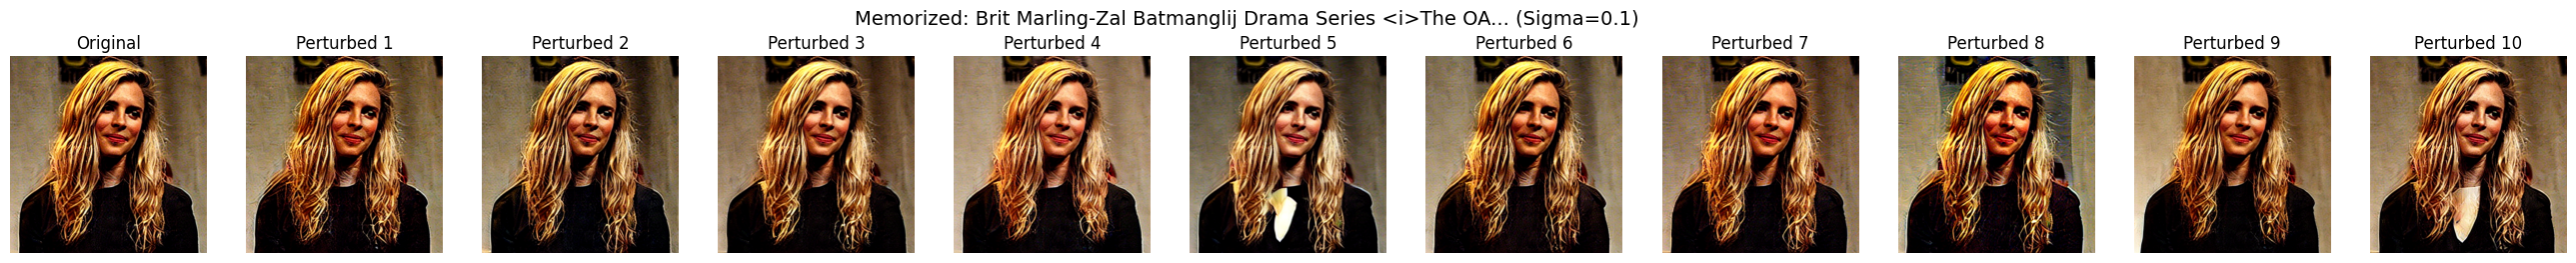

Processing Unmemorized: A ancient ruin covered in vines and moss


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

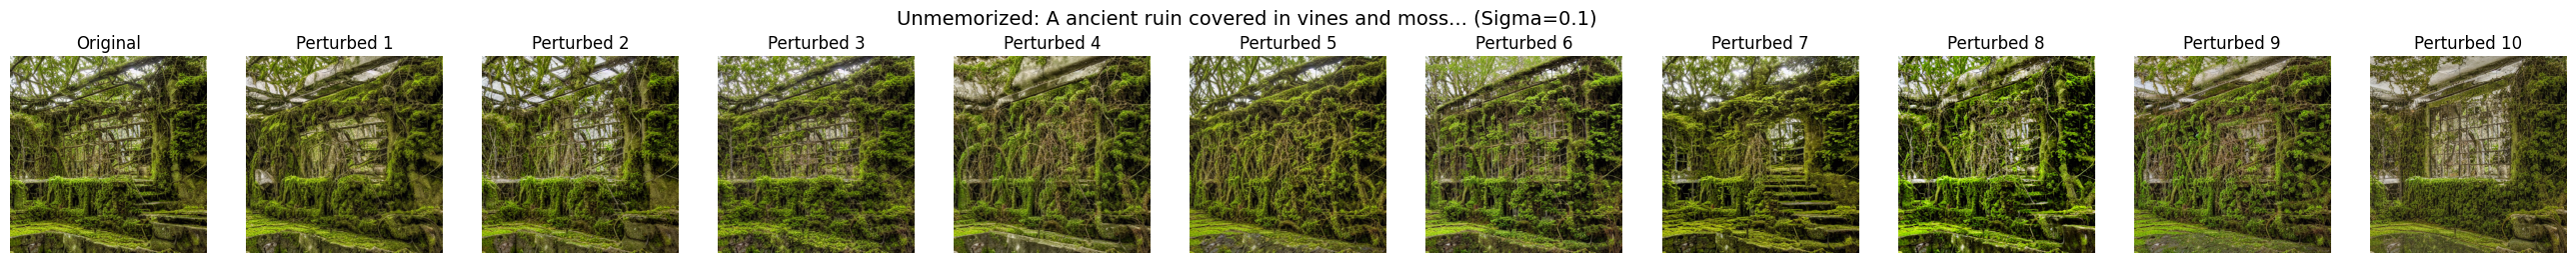

Combining results into comparison plots...


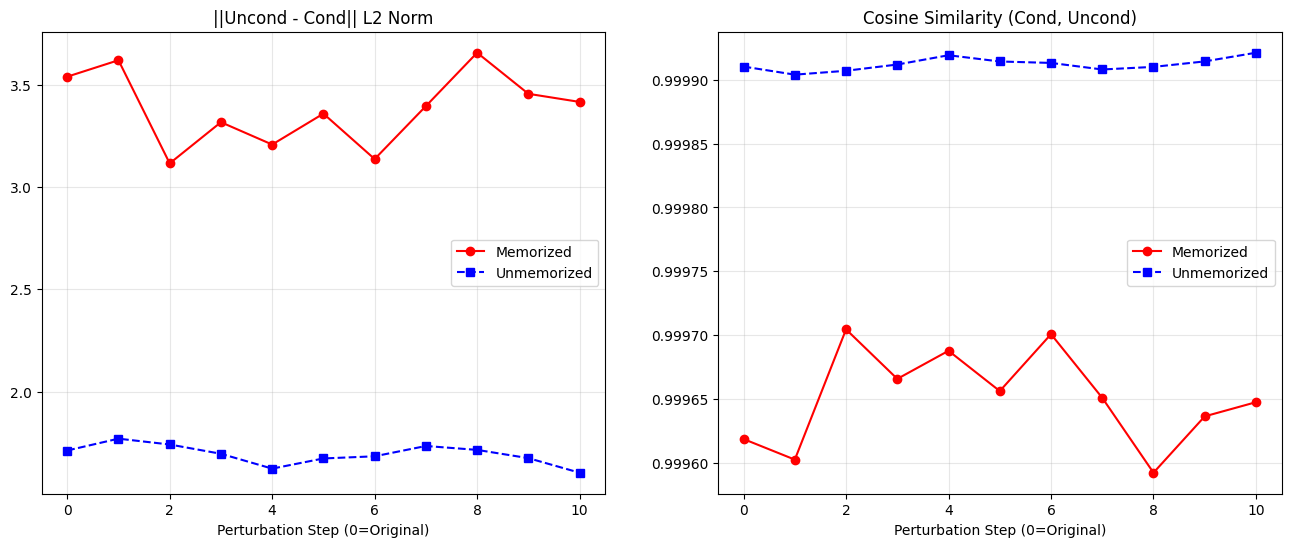

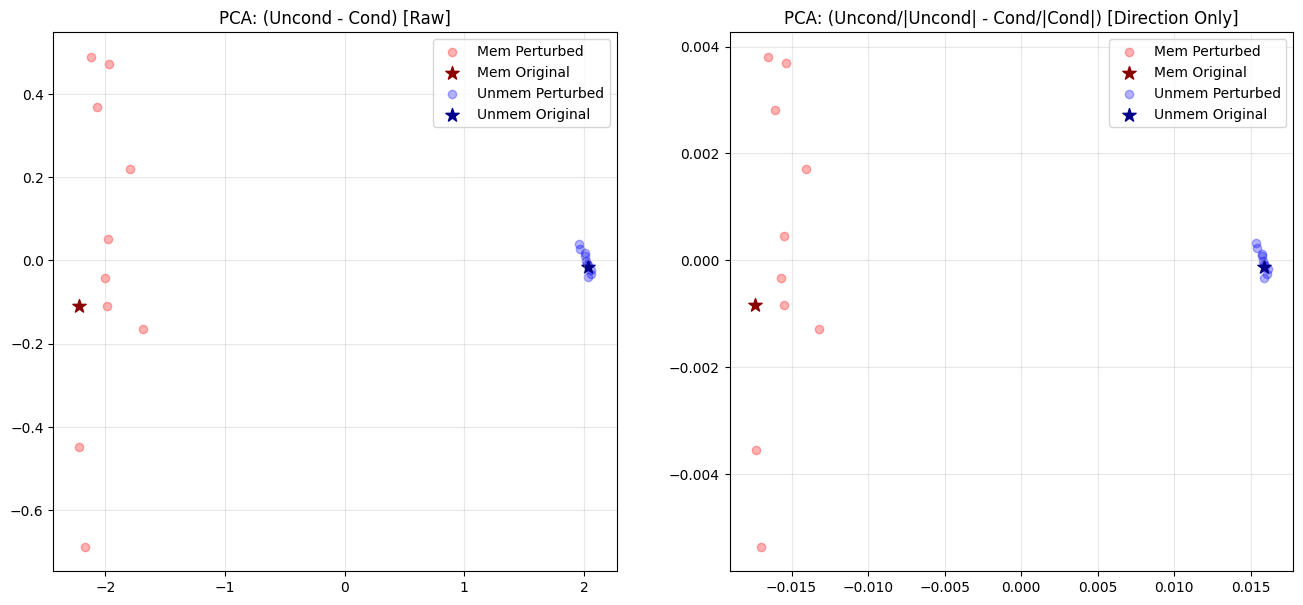

In [10]:
# Settings
n = 10  # Increased for distribution plot
noise_scale = 0.1 
seed = 42

target_mem_prompt = memorized_prompts[40] 
target_unmem_prompt = unmemorized_prompts[40]

# 1. Memorized Experiment
print(f"Processing Memorized: {target_mem_prompt}")
base_emb_mem = get_base_embedding(pipe, target_mem_prompt)
emb_list_mem = generate_perturbed_embeddings(base_emb_mem, n, noise_scale)
imgs_mem = generate_images_from_embeddings(pipe, emb_list_mem, seed=seed)
visualize_results(imgs_mem, "Memorized", target_mem_prompt, noise_scale)

# Noise Analysis (Mem)
cond_noises_mem, diff_vecs_mem, metrics_mem, uncond_noise_mem = analyze_conditional_noise_distribution(pipe, target_mem_prompt, emb_list_mem, seed=seed)

# 2. Unmemorized Experiment
print(f"Processing Unmemorized: {target_unmem_prompt}")
base_emb_unmem = get_base_embedding(pipe, target_unmem_prompt)
emb_list_unmem = generate_perturbed_embeddings(base_emb_unmem, n, noise_scale)
imgs_unmem = generate_images_from_embeddings(pipe, emb_list_unmem, seed=seed)
visualize_results(imgs_unmem, "Unmemorized", target_unmem_prompt, noise_scale)

# Noise Analysis (Unmem)
cond_noises_unmem, diff_vecs_unmem, metrics_unmem, uncond_noise_unmem = analyze_conditional_noise_distribution(pipe, target_unmem_prompt, emb_list_unmem, seed=seed)

# 3. Comparative Visualization
print("Combining results into comparison plots...")
compare_noise_analysis(cond_noises_mem, diff_vecs_mem, metrics_mem, uncond_noise_mem,
                       cond_noises_unmem, diff_vecs_unmem, metrics_unmem, uncond_noise_unmem)

Calculating Jacobians for 30 samples each...


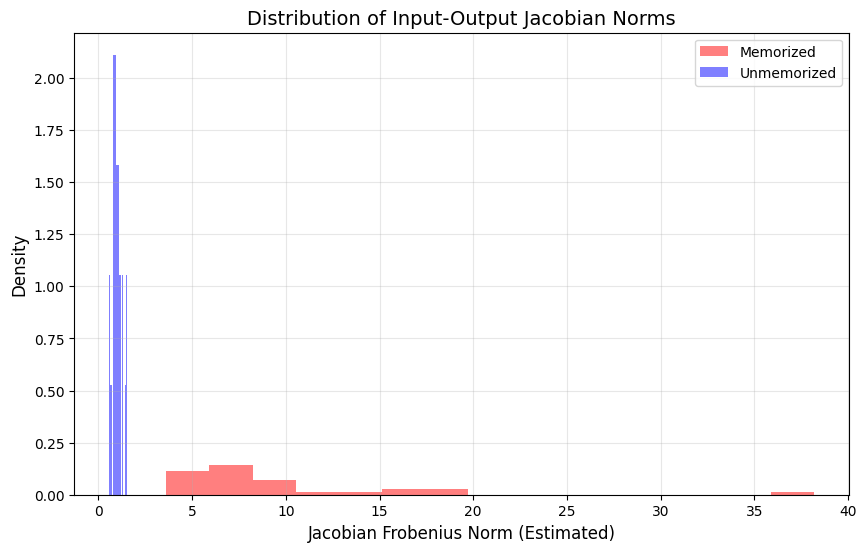

Mean Jacobian (Mem):   9.6697
Mean Jacobian (Unmem): 1.0032


In [9]:
# 4. Jacobian (Optional Check)
jac_mem, jac_unmem = analyze_jacobians(pipe, memorized_prompts, unmemorized_prompts, n_samples=30)
plot_jacobian_comparison(jac_mem, jac_unmem)